# Q6-10 and Define Your Own Task

## Q6

In [1]:
import igraph as ig
import json
from tqdm.notebook import trange, tqdm
import numpy as np
import pandas as pd

In [2]:
g_data = pd.read_csv('data/los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv', usecols=['sourceid', 'dstid', 'mean_travel_time', 'month'])

In [3]:
g_data

,sourceid,dstid,month,mean_travel_time
0,17,296,10,1109.36
1,28,186,10,1625.16
2,758,972,12,953.55
3,1212,547,10,2053.39
4,1299,1221,11,1467.54
...,...,...,...,...
5144057,1116,953,12,1336.86
5144058,1732,1170,10,1913.06
5144059,1167,443,12,1467.28
5144060,352,1086,10,1306.80


In [4]:
g_data = g_data.drop(g_data[g_data.month != 12].index)
g_data = g_data.drop(['month'], axis=1)

In [5]:
sd=np.hstack((np.asarray(g_data.sourceid).reshape(-1,1), np.asarray(g_data.dstid).reshape(-1,1)))

In [6]:
gd=np.asanyarray(g_data)

In [7]:
filtered_xy = {}
for x,y,z in tqdm(gd):
    key = tuple(np.sort([int(x), int(y)]))
    if key in filtered_xy: filtered_xy[key].append(z)
    else: filtered_xy[key] = [z]

In [8]:
with open('data/filtered_xy.txt','w') as f:
    for loc in tqdm(filtered_xy):
        f.write('{} {} {:.6f}\n'.format(loc[0], loc[1], np.mean(filtered_xy[loc])))

In [9]:
g = ig.Graph.Read(f = 'data/filtered_xy.txt', format = 'ncol', directed = False)
gcc = g.components().giant()
ig.summary(g)

IGRAPH UNW- 2649 1004955 -- 
+ attr: name (v), weight (e)


In [10]:
loc_meta = {}
with open('data/los_angeles_censustracts.json', 'r') as f:
    data = json.loads(f.readline())
    for feature in data['features']:
        coordinates = np.array(feature['geometry']['coordinates'][0][0])
        loc_meta[feature['properties']['MOVEMENT_ID']] = {'address': feature['properties']['DISPLAY_NAME'],
                                                          'mean_coords': np.mean(coordinates.reshape(-1,2), axis=0)}

In [11]:
seq = gcc.vs()
for i in seq:
    i['location'] = loc_meta[i['name']]['mean_coords']
ig.summary(gcc)

IGRAPH UNW- 2649 1004955 -- 
+ attr: location (v), name (v), weight (e)


In [12]:
gcc.vs()[0]

igraph.Vertex(<igraph.Graph object at 0x0000027EF5ABED68>, 0, {'name': '758', 'location': array([-118.556068,   34.288192])})

## Q7

In [13]:
mst = gcc.spanning_tree(weights = gcc.es["weight"])
ig.summary(mst)

IGRAPH UNW- 2649 2648 -- 
+ attr: location (v), name (v), weight (e)


In [14]:
len(mst.es())

2648

In [589]:
mst_edges = mst.es()
for e in mst_edges[:10]:
    x, y = mst.vs(e.tuple[0])[0]['name'], mst.vs(e.tuple[1])[0]['name']
    print(loc_meta[str(x)]['address'], loc_meta[str(y)]['address'])

Census Tract 554001 Census Tract 554002
Census Tract 461700 Census Tract 460800
Census Tract 302201 Census Tract 302202
Census Tract 407101 Census Tract 407002
Census Tract 433401 Census Tract 433402
Census Tract 543603 Census Tract 294410
Census Tract 482001 Census Tract 530700
Census Tract 460800 Census Tract 463800
Census Tract 269100 Census Tract 217001
Census Tract 011000 Census Tract 001901


In [611]:
#Haversine formula
def getDistanceFromLatLonInMiles(lat1,lon1,lat2,lon2):
    R = 6371;
    dLat = np.radians(lat2-lat1);
    dLon = np.radians(lon2-lon1); 
    a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) *  np.sin(dLon/2) * np.sin(dLon/2); 
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)); 
    d = R * c;
    return d * 0.621371;

In [597]:
for i,e in enumerate(mst_edges[:10]):
    x, y = mst.vs(e.tuple[0])[0]['name'], mst.vs(e.tuple[1])[0]['name']
    #print(loc_meta[str(x)]['mean_coords'], loc_meta[str(y)]['mean_coords'])
    print(loc_meta[str(x)]['address'], '&', loc_meta[str(y)]['address'],'&','{:.2f}'.format(e['weight']),'&','{:.2f}'.format(getDistanceFromLatLonInMiles(loc_meta[str(x)]['mean_coords'][1], loc_meta[str(x)]['mean_coords'][0], loc_meta[str(y)]['mean_coords'][1], loc_meta[str(y)]['mean_coords'][0])),'\\\ \hline')

Census Tract 554001 & Census Tract 554002 & 103.60 & 0.70 \\ \hline
Census Tract 461700 & Census Tract 460800 & 85.56 & 1.99 \\ \hline
Census Tract 302201 & Census Tract 302202 & 108.76 & 0.29 \\ \hline
Census Tract 407101 & Census Tract 407002 & 114.10 & 1.05 \\ \hline
Census Tract 433401 & Census Tract 433402 & 71.14 & 0.32 \\ \hline
Census Tract 543603 & Census Tract 294410 & 85.17 & 0.41 \\ \hline
Census Tract 482001 & Census Tract 530700 & 104.78 & 0.61 \\ \hline
Census Tract 460800 & Census Tract 463800 & 63.25 & 2.70 \\ \hline
Census Tract 269100 & Census Tract 217001 & 124.38 & 0.93 \\ \hline
Census Tract 011000 & Census Tract 001901 & 109.50 & 1.22 \\ \hline


## Q8

In [18]:
def check_triangle_exists(g, v):
    v1, v2, v3 = v
    if g.get_eid(v1, v2, directed=False, error=False)!=-1 and g.get_eid(v1, v3, directed=False, error=False)!=-1 and g.get_eid(v2, v3, directed=False, error=False)!=-1:
        return True
    else:
        return False

In [19]:
def get_triangle_edges(g, v):
    v1, v2, v3 = v
    e=[g.get_eid(v1, v2, directed=False, error=False), g.get_eid(v1, v3, directed=False, error=False), g.get_eid(v2, v3, directed=False, error=False)]
    assert(e[0]!=-1 and e[1]!=-1 and e[2]!=-1)
    return e

In [20]:
triangles = set()
vids = range(len(gcc.vs()))
counter =0

for i in tqdm(range(1000)):
    tri = np.random.choice(vids, 3, replace=False)
    tri_tup = tuple(np.sort(tri))
    while tri_tup in triangles or not check_triangle_exists(gcc, tri_tup):
        tri = np.random.choice(vids, 3, replace=False)
        tri_tup = tuple(np.sort(tri))
    
    edges = get_triangle_edges(gcc, tri_tup)
    assert(tri_tup not in triangles)
    assert(len(edges)==3)
    triangles.add(tri_tup)
    weights = [edge['weight'] for edge in gcc.es(edges)]
    if weights[0]+weights[1]>=weights[2] and weights[1]+weights[2]>=weights[0] and weights[0]+weights[2]>=weights[1]:
        counter+=1

print(counter/1000)


0.928


## Q9

In [21]:
gcc_distances = np.array(gcc.shortest_paths(weights = gcc.es()['weight']))

In [22]:
def preorderTraversal(g, root): 
    stack = []
    preorder =[] 
    preorder.append(root) 
    stack.append(root) 
    while len(stack)>0:
        flag = 0
        if g.vs(stack[-1])[0].degree(mode='OUT') == 0: 
            stack.pop() 
        else: 
            par = stack[-1]
        for child in g.vs(par)[0].neighbors(mode='OUT'): 
            if child.index not in preorder: 
                flag = 1
                stack.append(child.index) 
                preorder.append(child.index) 
                break;
        if flag == 0: 
            stack.pop() 
    return preorder

In [23]:
pre=preorderTraversal(mst, 0)

In [599]:
def get_vid_by_a(g,name,val):
    for v in g.vs():
        if v[name]==val:
            return v.index
    1/0

In [602]:
total_weight = 0
final_path = []
for i in tqdm(range(len(pre) - 1)):
    index1 = get_vid_by_a(gcc,'name',mst.vs(pre[i])[0]['name'])
    index2 = get_vid_by_a(gcc,'name',mst.vs(pre[i+1])[0]['name'])
    eid=gcc.get_eid(index1, index2, directed=False, error=False)
    if eid != -1:
        total_weight += gcc.es(eid)[0]['weight']
        final_path.append(index1)
        final_path.append(index2)
    else:
        total_weight += (gcc.shortest_paths(index1, index2, weights = gcc.es()['weight']))[0][0]
        path1 = gcc.get_shortest_paths(index1, index2, weights = gcc.es()['weight'], output='vpath')
        for ind in path1[0]:
            final_path.append(ind)

print('total weight: ' + str(total_weight))


total weight: 473196.41499999975


In [608]:
sum(mst.es['weight'])

269084.5449999998

In [607]:
upper_bound = total_weight / sum(mst.es['weight'])
print(upper_bound)

1.758541780985601


## Q10

In [612]:
with open('data/santa_path_new.csv', 'w') as f:
    f.write('Longitude, Latitude, Line Group (Path ID), Order of Points \n')
    loc = gcc.vs[final_path[0]]['location']
    f.write(str(loc[0]) + ', ' + str(loc[1]) + ', ' + '1, 1 \n')
    order = 2
    for i in range(1, len(final_path) - 1):
        if i%2 != 0:
            location = gcc.vs[final_path[i]]['location']
            f.write(str(location[0]) + ', ' + str(location[1]) + ', ' + '1, ' + str(order) + '\n')
            order += 1
    loc = gcc.vs[final_path[len(final_path) - 1]]['location']
    f.write(str(loc[0]) + ', ' + str(loc[1]) + ', ' + '1, ' + str(order) + '\n')

## Define Your Own Task

### Generate request dataset

In [29]:
from functools import partial
import matplotlib.pyplot as plt
from scipy import stats

In [229]:
[*range(0,1400,100)]

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300]

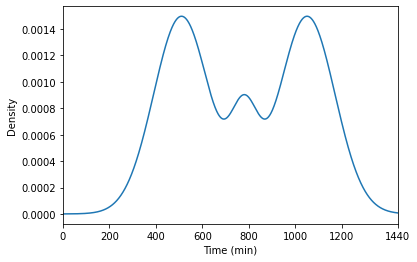

In [290]:
loc1, scale1, size1 = (510, 120, 450)
loc2, scale2, size2 = (780, 60, 100)
loc3, scale3, size3 = (1050, 120, 450)
x2 = np.concatenate([np.random.normal(loc=loc1, scale=scale1, size=size1),
                     np.random.normal(loc=loc2, scale=scale2, size=size2), np.random.normal(loc=loc3, scale=scale3, size=size3)])

x_eval = np.arange(1440)

bimodal_pdf = stats.norm.pdf(x_eval, loc=loc1, scale=scale1) * float(size1) / x2.size + \
              stats.norm.pdf(x_eval, loc=loc2, scale=scale2) * float(size2) / x2.size + \
              stats.norm.pdf(x_eval, loc=loc3, scale=scale3) * float(size3) / x2.size

bimodal_pdf /= bimodal_pdf.sum()

plt.plot(x_eval, bimodal_pdf)

plt.xlim([x_eval.min(), x_eval.max()])
plt.xlabel('Time (min)')
plt.ylabel('Density')
plt.xlim([0, 1440])
ticks=[*range(0,1400,200)]
ticks.append(1440)
plt.xticks(ticks)
plt.savefig('plots/density.png', dpi=600, bbox_inches='tight')
plt.show()

In [31]:
bimodal_pdf.shape

(1440,)

In [32]:
bimodal_pdf.sum()

1.0

In [33]:
times=np.random.choice(range(1440), 1000, p=bimodal_pdf)

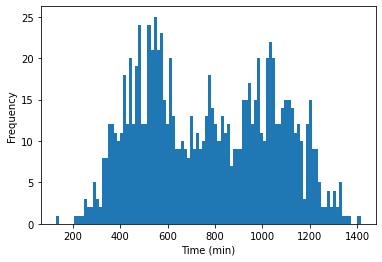

In [291]:
plt.hist(times, 100)
plt.xlabel('Time (min)')
plt.ylabel('Frequency')
plt.savefig('plots/hist_sample.png', dpi=600, bbox_inches='tight')

In [35]:
times=np.sort(times)

In [135]:
requests = []
trips = set()
vids = range(len(gcc.vs()))
counter =0

for i in tqdm(range(1000)):
    trip = np.random.choice(vids, 2, replace=False)
    trip_tup = tuple(np.sort(trip))
    while trip_tup in trips:
        trip = np.random.choice(vids, 2, replace=False)
        trip_tup = tuple(np.sort(trip))
    
    assert(trip_tup not in trips)
    trips.add(trip_tup)
    requests.append([times[i], trip_tup[0], trip_tup[1]])

In [105]:
vids

range(0, 2649)

In [125]:
tuple(np.sort(np.random.choice(vids, 2, replace=False)))

(1550, 1726)

In [136]:
requests = np.array(requests)

In [579]:
# requests_pickle={}
# requests_pickle['requests']=requests
# pickle.dump(requests_pickle, open('data/requests.pkl', 'wb'))

In [137]:
requests[0,:]

array([ 129, 1225, 2499])

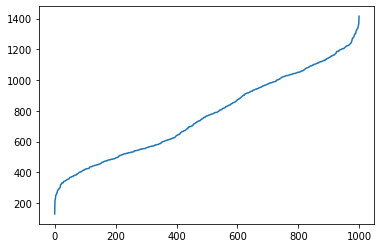

In [138]:
plt.plot(requests[:,0])

In [142]:
with open('data/requests_start_end.csv', 'w') as f:
    f.write('Longitude, Latitude, Line Group (Path ID), Order of Points \n')
    count=0
    for i,j,k in requests:
        locx = gcc.vs[j]['location']
        locy = gcc.vs[k]['location']
        count+=1
        f.write(str(locx[0]) + ', ' + str(locx[1]) + ', ' + str(count) + ', ' + str(1) + '\n')
        f.write(str(locy[0]) + ', ' + str(locy[1]) + ', ' + str(count) + ', ' + str(2) + '\n')
    

In [40]:
gcc_distances[0]

array([   0.   ,  985.375, 1971.47 , ..., 1501.525, 1118.955, 1575.615])

In [143]:
n_e=0
delta=5
g1_edges = []
for i in trange(1000):
    for j in range(i+1, 1000):
        t1, t2 = requests[i, 0], requests[j, 0]
        assert(t1 <= t2)
        src1, dst1 = requests[i, 1], requests[i, 2]
        src2, dst2 = requests[j, 1], requests[j, 2]
        arriv_at_2 = t1+gcc_distances[src1][dst1]/60+gcc_distances[dst1][src2]/60
        if arriv_at_2 <= t2+delta:
            n_e+=1
            g1_edges.append((i,j))

In [144]:
len(g1_edges)

437604

In [145]:
g1 = ig.Graph(1000, directed=True)
g1.add_edges(g1_edges)

In [146]:
g1.summary()

'IGRAPH D--- 1000 437604 -- '

### Subtask 1

In [147]:
length_to = np.zeros(1000, dtype=int)
from_to = np.zeros(1000, dtype=int)-1
top_order = g1.topological_sorting(mode='OUT')

In [148]:
for v in top_order:
    for w in g1.vs(v)[0].neighbors(mode='OUT'):
        if length_to[w.index] <= length_to[v] + 1:
            length_to[w.index] = length_to[v] + 1
            from_to[w.index] = v

In [149]:
max_req, endpoint = np.amax(length_to), int(np.argmax(length_to))

In [150]:
print(max_req, endpoint)

36 999


In [151]:
curr=[endpoint]
while curr[-1]!=-1:
    curr.append(from_to[curr[-1]])

In [152]:
path_to_take = curr[:-1]
path_to_take.reverse()

In [153]:
print(path_to_take)

[0, 7, 14, 29, 56, 74, 147, 170, 188, 229, 265, 337, 359, 400, 430, 456, 484, 502, 544, 577, 597, 634, 672, 707, 729, 763, 789, 829, 868, 884, 906, 940, 967, 982, 989, 993, 999]


In [277]:
with open('data/requests_single_path.csv', 'w') as f:
    f.write('Longitude, Latitude, Line Group (Path ID), Order of Points, Color \n')
    count=0
    for i,j in enumerate(path_to_take):
        _,l1,l2 = requests[j]
        locx = gcc.vs[l1]['location']
        locy = gcc.vs[l2]['location']
        f.write(str(locx[0]) + ', ' + str(locx[1]) + ', ' + str(count+1) + ', ' + str(2*i+1) + ', 2\n')
        f.write(str(locy[0]) + ', ' + str(locy[1]) + ', ' + str(count+1) + ', ' + str(2*i+2) + ', 2\n')
        
    for i,j,k in requests:
        locx = gcc.vs[j]['location']
        locy = gcc.vs[k]['location']
        count+=1
        f.write(str(locx[0]) + ', ' + str(locx[1]) + ', ' + str(count) + ', ' + str(1) + ', 1\n')
        f.write(str(locy[0]) + ', ' + str(locy[1]) + ', ' + str(count) + ', ' + str(2) + ', 1\n')

In [154]:
rejected=np.setdiff1d(np.arange(1000), path_to_take)

In [155]:
times[path_to_take]

array([ 129,  266,  292,  339,  371,  389,  453,  474,  485,  520,  540,
        580,  601,  639,  675,  712,  748,  767,  805,  839,  864,  916,
        951,  981,  999, 1029, 1044, 1080, 1116, 1127, 1152, 1199, 1230,
       1281, 1313, 1332, 1415])

In [156]:
requests[path_to_take, 0]

array([ 129,  266,  292,  339,  371,  389,  453,  474,  485,  520,  540,
        580,  601,  639,  675,  712,  748,  767,  805,  839,  864,  916,
        951,  981,  999, 1029, 1044, 1080, 1116, 1127, 1152, 1199, 1230,
       1281, 1313, 1332, 1415])

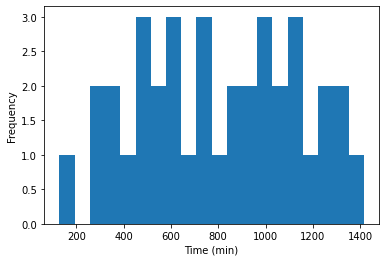

In [568]:
plt.hist(times[path_to_take], bins=20)
plt.xlabel('Time (min)')
plt.ylabel('Frequency')
plt.savefig('plots/hist_path.png', dpi=600, bbox_inches='tight')

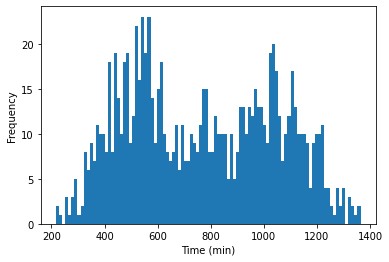

In [570]:
plt.hist(times[rejected], 100)
plt.xlabel('Time (min)')
plt.ylabel('Frequency')
plt.savefig('plots/hist_rejected.png', dpi=600, bbox_inches='tight')

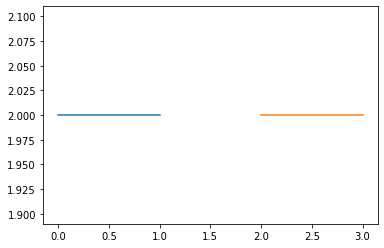

In [159]:
f = plt.figure()
plt.plot([0, 1],[2, 2])
plt.plot([2, 3],[2, 2])

In [160]:
delta

5

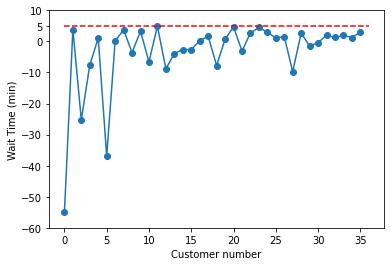

In [572]:
wait_times=[]
for k in range(len(path_to_take)-1):
    i=path_to_take[k]
    j=path_to_take[k+1]
    t1, t2 = requests[i, 0], requests[j, 0]
    src1, dst1 = requests[i, 1], requests[i, 2]
    src2, dst2 = requests[j, 1], requests[j, 2]
    arriv_at_2 = t1+gcc_distances[src1][dst1]/60+gcc_distances[dst1][src2]/60
    #print(arriv_at_2, t2+delta)
    assert(arriv_at_2 <= t2+delta)
    wait_times.append(arriv_at_2-t2)
plt.plot(wait_times, '-o')
plt.xlabel('Customer number')
plt.ylabel('Wait Time (min)')
plt.ylim([-60, 10])
ticks=[*range(-60,11,10)]
ticks.append(5)
plt.yticks(ticks)
plt.plot([0, 36],[5,5], '--r')
plt.savefig('plots/hist_wait_times1.png', dpi=600, bbox_inches='tight')

In [162]:
max(wait_times)

4.904999999999973

(100.0, 300.0)

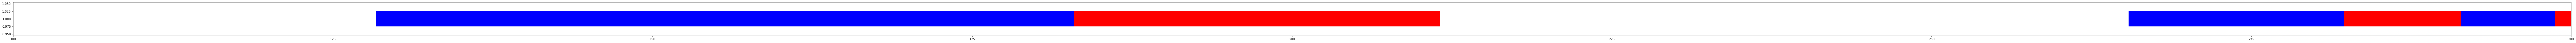

In [163]:
plt.figure(figsize=(150, 2))
for k in range(5):
    i=path_to_take[k]
    j=path_to_take[k+1]
    t1, t2 = requests[i, 0], requests[j, 0]
    src1, dst1 = requests[i, 1], requests[i, 2]
    src2, dst2 = requests[j, 1], requests[j, 2]
    arriv_at_2 = t1+gcc_distances[src1][dst1]/60+gcc_distances[dst1][src2]/60
    #print(arriv_at_2, t2+delta)
    assert(arriv_at_2 <= t2+delta)
    plt.plot([t1, t1+gcc_distances[src1][dst1]/60],[1, 1], '-b', linewidth=50)
    plt.plot([t1+gcc_distances[src1][dst1]/60, arriv_at_2],[1, 1], '-r', linewidth=50)
plt.xlim([100, 300])

(350.0, 650.0)

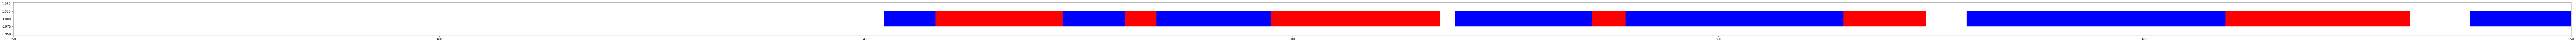

In [164]:
plt.figure(figsize=(150, 2))
for k in range(6, 20):
    i=path_to_take[k]
    j=path_to_take[k+1]
    t1, t2 = requests[i, 0], requests[j, 0]
    src1, dst1 = requests[i, 1], requests[i, 2]
    src2, dst2 = requests[j, 1], requests[j, 2]
    arriv_at_2 = t1+gcc_distances[src1][dst1]/60+gcc_distances[dst1][src2]/60
    #print(arriv_at_2, t2+delta)
    assert(arriv_at_2 <= t2+delta)
    plt.plot([t1, t1+gcc_distances[src1][dst1]/60],[1, 1], '-b', linewidth=50)
    plt.plot([t1+gcc_distances[src1][dst1]/60, arriv_at_2],[1, 1], '-r', linewidth=50)
plt.xlim([350, 650])

In [165]:
#ig.plot(g1_mst, vertex_size=1, edge_arrow_size=0.5)

In [166]:
#length_to

In [167]:
# for v in top_order:
#     if len(g1.vs(v)[0].neighbors(mode='OUT'))>0:
#         print(v, len(g1.vs(v)[0].neighbors(mode='OUT')))

In [168]:
# for v in top_order:
#     if len(g1.vs(v)[0].neighbors(mode='OUT'))>0 and len(g1.vs(v)[0].neighbors(mode='IN'))>0:
#         print(v)

### Subtask 2

In [169]:
g2 = ig.Graph(2002, directed=True)

In [170]:
g1_edges[0]

(0, 1)

In [171]:
g2_edges = [(x+1, 1000+y+1) for x, y in g1_edges]

In [172]:
g2_edges[0]

(1, 1002)

In [173]:
for x, y in g1_edges:
    g2_edges.append((0, x+1))
    g2_edges.append((1000+y+1, 2001))

In [174]:
g2.add_edges(g2_edges)

In [175]:
g2.simplify()

In [176]:
g2.es['capacity']=1

In [177]:
g2.summary()

'IGRAPH D--- 2002 439597 -- \n+ attr: capacity (e)'

In [178]:
g2_maxflow = g2.maxflow(0, 2001, capacity='capacity')

In [179]:
g2.maxflow_value(0, 2001, capacity='capacity')

917.0

In [180]:
g2_maxflow.value

917.0

In [181]:
g2_maxflow.summary()

'Clustering with 2002 elements and 2 clusters'

In [182]:
flows = np.array(g2_maxflow.flow)

In [183]:
len(flows)

439597

In [184]:
len(np.where(flows==1)[0])

2751

In [185]:
np.unique(flows)

array([0., 1.])

In [274]:
fff=0
for i in range(len(flows)):
    flow=flows[i]
    assert(flow==0 or flow==1)
    if(flow==1):
        e=g2.es(i)[0]
        if e.target==2001:
            fff+=1
print(fff)

917


In [186]:
start_of_path = [True] * 1000
mpc={} 
for i in range(len(flows)):
    flow=flows[i]
    assert(flow==0 or flow==1)
    if(flow==1):
        e=g2.es(i)[0]
        if e.source==0 or e.target==2001: continue
        src, dst =e.source-1, e.target-1000-1
        mpc[src]=dst
        start_of_path[dst] = False

In [187]:
sum(start_of_path)

83

In [188]:
mpc_paths = []
for i in range(1000):
    if start_of_path[i]:
        curr = [i]
        while curr[-1] in mpc:
            curr.append(mpc[curr[-1]])
        mpc_paths.append(curr)

In [189]:
mpc_paths = np.array(mpc_paths)

In [190]:
mpc_paths

array([list([0, 125, 195, 259, 337, 359, 452, 534, 604, 681, 767, 843, 914, 943, 979, 999]),
       list([1, 96, 182, 260]), list([2, 92, 183, 266, 305]),
       list([3, 162, 212, 326, 421, 522, 596, 656, 723, 815, 849, 902, 948]),
       list([4, 161, 236, 318, 384, 462, 512, 561, 636, 743, 807, 835, 897, 922, 962]),
       list([5, 146, 272, 369, 448, 540, 627, 700, 761]),
       list([6, 158, 228, 303, 367, 501, 571, 618, 677, 708, 803, 862, 945, 981]),
       list([7, 157, 232, 341, 445, 537, 573, 615, 670, 739]),
       list([8, 156, 277, 364, 400, 493, 603, 680, 736, 793, 850, 905, 957]),
       list([9, 149, 241, 316, 409, 446, 480, 517, 560, 606, 675, 702, 781, 836, 918, 959]),
       list([10, 148, 242, 373, 422, 495, 587, 671, 712, 796, 854, 906]),
       list([11, 140, 203, 283]), list([12, 139, 250]),
       list([13, 129, 196, 264]),
       list([14, 128, 207, 280, 360, 439, 539, 597, 646, 692, 772, 833, 876, 915, 947]),
       list([15, 127, 218, 289, 349, 435, 503, 581,

In [255]:
#sanity check
mpc_union=mpc_paths[0]
mpc_intersection=mpc_paths[0]
for i, mpc_path in enumerate(mpc_paths[1:]):
    mpc_union=np.union1d(mpc_union, mpc_path)
    mpc_intersection=np.intersect1d(mpc_intersection, mpc_path)
print(np.all(mpc_union==[*range(1000)]))
print(mpc_intersection)

True
[]


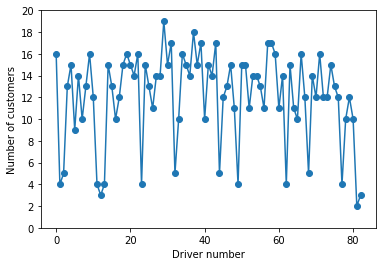

In [574]:
plt.plot([len(p) for p in mpc_paths], '-o')
plt.yticks([*range(0, 21, 2)])
plt.xlabel('Driver number')
plt.ylabel('Number of customers')
plt.savefig('plots/driver_customers.png', dpi=600, bbox_inches='tight')

In [ ]:
np.union1d()

In [505]:
# for i,j in enumerate(path_to_take):
#         _,l1,l2 = requests[j]
#         locx = gcc.vs[l1]['location']
#         locy = gcc.vs[l2]['location']
#         f.write(str(locx[0]) + ', ' + str(locx[1]) + ', ' + str(count+1) + ', ' + str(2*i+1) + ', 2\n')
#         f.write(str(locy[0]) + ', ' + str(locy[1]) + ', ' + str(count+1) + ', ' + str(2*i+2) + ', 2\n')

In [278]:
with open('data/requests_multiple_paths.csv', 'w') as f:
    f.write('Longitude, Latitude, Line Group (Path ID), Order of Points, Color \n')
    count=0
    color=0
    for i, mpc_path in enumerate(mpc_paths):
        count+=1
        color+=1
        for j, loc in enumerate(mpc_path):
            _,l1,l2 = requests[loc]
            locx = gcc.vs[l1]['location']
            locy = gcc.vs[l2]['location']
            f.write(str(locx[0]) + ', ' + str(locx[1]) + ', ' + str(count) + ', ' + str(2*j+1) + ', ' + str(color)+' \n')
            f.write(str(locy[0]) + ', ' + str(locy[1]) + ', ' + str(count) + ', ' + str(2*j+2) + ', ' + str(color)+' \n')
    for i,j,k in requests:
        locx = gcc.vs[j]['location']
        locy = gcc.vs[k]['location']
        count+=1
        f.write(str(locx[0]) + ', ' + str(locx[1]) + ', ' + str(count) + ', ' + str(1) + ', ' + str(color+1) + ' \n')
        f.write(str(locy[0]) + ', ' + str(locy[1]) + ', ' + str(count) + ', ' + str(2) + ', ' + str(color+1) + ' \n')

In [280]:
max_wait_times=[]
for mpc_path in mpc_paths:
    max_wait_time=-1e18
    for k in range(len(mpc_path)-1):
        i=mpc_path[k]
        j=mpc_path[k+1]
        t1, t2 = requests[i, 0], requests[j, 0]
        src1, dst1 = requests[i, 1], requests[i, 2]
        src2, dst2 = requests[j, 1], requests[j, 2]
        arriv_at_2 = t1+gcc_distances[src1][dst1]/60+gcc_distances[dst1][src2]/60
        #print(arriv_at_2, t2+delta)
        assert(arriv_at_2 <= t2+delta)
        max_wait_time=max(max_wait_time, arriv_at_2-t2)
    max_wait_times.append(max_wait_time)

In [281]:
max(max_wait_times)

4.9583333333332575

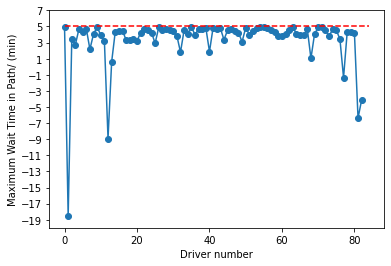

In [576]:
plt.plot(max_wait_times, '-o')
plt.ylim([min(max_wait_times)-1, delta+1])
plt.yticks(range(int(min(max_wait_times)-1),delta+3, 2))
plt.xlabel('Driver number')
plt.ylabel('Maximum Wait Time in Path/ (min)')
plt.ylim([-20, 7])
# ticks=[*range(-60,11,10)]
# ticks.append(5)
# plt.yticks(ticks)
plt.plot([0, 84],[5,5], '--r')
plt.savefig('plots/hist_wait_times2.png', dpi=600, bbox_inches='tight')

### Subtask 3

In [450]:
D1=50

In [451]:
n31=2002

In [487]:
def edge_type(e):
    i,j=e
    if i==0:
        return 'source'
    elif j==2001:
        return 'sink'
    elif (j==i+1) and i%2==1:
        return 'internal'
    else:
        return 'external'

In [453]:
# g3_edges=[]
# edge_id={}
# for v in g1.vs():
#     i=v.index
#     if v.degree(mode='IN') == 0:
#         g3_edges.append((0, i*2+1))
#     if v.degree(mode='OUT') == 0:
#         g3_edges.append((i*2+2, 2001))
#     g3_edges.append((i*2+1, i*2+2))
# for e in g1.es():
#     i, j=e.source, e.target
#     g3_edges.append((i*2+2, j*2+1))
# g3_edges.append((2001,0))
# for i, e in enumerate(g3_edges):
#     edge_id[e]=i
# e3=len(g3_edges)

In [456]:
g3_edges1=[]
edge_id1={}
for v in g1.vs():
    i=v.index
    g3_edges1.append((0, i*2+1))
    g3_edges1.append((i*2+2, 2001))
    g3_edges1.append((i*2+1, i*2+2))
for e in g1.es():
    i, j=e.source, e.target
    g3_edges1.append((i*2+2, j*2+1))
g3_edges1.append((2001,0))
for i, e in enumerate(g3_edges1):
    edge_id1[e]=i
e31=len(g3_edges1)

In [457]:
M1=np.zeros((e31,n31))
c1=np.ones((e31,1))
c1[-1]=10000
a1=np.zeros((e31,1))
e_n1=np.zeros((e31,1))
e_n1[-1]=1

for i in range(1000):
    a1[edge_id1[(i*2+1,i*2+2)]]=-1
for i,e in enumerate(g3_edges1):
    j, k=e
    M1[i,j]=-1
    M1[i,k]=1

In [458]:
#import pickle

In [462]:
print(e31)

440605


In [463]:
# g3_pickle={}
# g3_pickle['n3']=n3
# g3_pickle['e3']=e3
# g3_pickle['edge_id']=edge_id
# g3_pickle['g3_edges']=g3_edges
# g3_pickle['c']=c
# g3_pickle['a']=a
# g3_pickle['e_n']=e_n
# pickle.dump(g3_pickle, open("data/g3_1.pkl", "wb" ))

In [464]:
# f1 = cp.Variable((e31,1), integer=True)
# constraints1 = [M1.T@f1<=0, f1>=0, e_n1.T@f1<=D1, e_n1.T@f1>=D1, f1<=c1]
# obj1 = cp.Minimize(a1.T@f1)
# prob1 = cp.Problem(obj1, constraints1)
# prob1.solve(verbose=True)

In [465]:
#f1.value

### To save time, the linear program was exported, solved in a UCLA server and loaded back to this program (server code is in Subtask3.ipynb)

In [484]:
with open("data/g3_1_f.pkl", "rb" ) as f:
    f1_pickle=pickle.load(f)

In [491]:
f1=f1_pickle['f'][:-1]

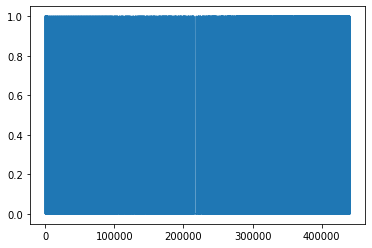

In [492]:
plt.plot(f1)

In [493]:
start_of_path3 = [True] * 1000
mpc3={} 
for i in range(len(f1)):
    flow=f1[i]
    assert(flow==0 or flow==1)
    if(flow==1 and edge_type(g3_edges1[i])=='external'):
        e=g3_edges1[i]
        src, dst =(e[0]-2)//2, (e[1]-1)//2
        mpc3[src]=dst
        start_of_path3[dst] = False

In [495]:
sum(start_of_path3)

156

In [499]:
mpc_paths3 = []
for i in range(1000):
    if start_of_path3[i]:
        curr = [i]
        while curr[-1] in mpc3:
            curr.append(mpc3[curr[-1]])
        if(len(curr)>1):
            mpc_paths3.append(curr)

In [500]:
mpc_paths3 = np.array(mpc_paths3)

In [501]:
len(mpc_paths3)

50

In [502]:
mpc_paths

array([list([0, 125, 195, 259, 337, 359, 452, 534, 604, 681, 767, 843, 914, 943, 979, 999]),
       list([1, 96, 182, 260]), list([2, 92, 183, 266, 305]),
       list([3, 162, 212, 326, 421, 522, 596, 656, 723, 815, 849, 902, 948]),
       list([4, 161, 236, 318, 384, 462, 512, 561, 636, 743, 807, 835, 897, 922, 962]),
       list([5, 146, 272, 369, 448, 540, 627, 700, 761]),
       list([6, 158, 228, 303, 367, 501, 571, 618, 677, 708, 803, 862, 945, 981]),
       list([7, 157, 232, 341, 445, 537, 573, 615, 670, 739]),
       list([8, 156, 277, 364, 400, 493, 603, 680, 736, 793, 850, 905, 957]),
       list([9, 149, 241, 316, 409, 446, 480, 517, 560, 606, 675, 702, 781, 836, 918, 959]),
       list([10, 148, 242, 373, 422, 495, 587, 671, 712, 796, 854, 906]),
       list([11, 140, 203, 283]), list([12, 139, 250]),
       list([13, 129, 196, 264]),
       list([14, 128, 207, 280, 360, 439, 539, 597, 646, 692, 772, 833, 876, 915, 947]),
       list([15, 127, 218, 289, 349, 435, 503, 581,

In [504]:
#sanity check
mpc_union3=mpc_paths3[0]
mpc_intersection3=mpc_paths3[0]
for i, mpc_path3 in enumerate(mpc_paths3[1:]):
    mpc_union3=np.union1d(mpc_union3, mpc_path3)
    mpc_intersection3=np.intersect1d(mpc_intersection3, mpc_path3)
print(len(mpc_union3))
print(mpc_intersection3)

894
[]


In [507]:
with open('data/requests_multiple_paths_50_drivers.csv', 'w') as f:
    f.write('Longitude, Latitude, Line Group (Path ID), Order of Points, Color, Covered \n')
    count=0
    color=0
    for i, mpc_path in enumerate(mpc_paths3):
        count+=1
        color+=1
        for j, loc in enumerate(mpc_path):
            _,l1,l2 = requests[loc]
            locx = gcc.vs[l1]['location']
            locy = gcc.vs[l2]['location']
            f.write(str(locx[0]) + ', ' + str(locx[1]) + ', ' + str(count) + ', ' + str(2*j+1) + ', ' + str(color)+', ' + str(1)+' \n')
            f.write(str(locy[0]) + ', ' + str(locy[1]) + ', ' + str(count) + ', ' + str(2*j+2) + ', ' + str(color)+', ' + str(1)+' \n')
    for i,j,k in requests:
        locx = gcc.vs[j]['location']
        locy = gcc.vs[k]['location']
        count+=1
        f.write(str(locx[0]) + ', ' + str(locx[1]) + ', ' + str(count) + ', ' + str(1) + ', ' + str(color+1) + ', ' + str(2)+' \n')
        f.write(str(locy[0]) + ', ' + str(locy[1]) + ', ' + str(count) + ', ' + str(2) + ', ' + str(color+1) + ', ' + str(2)+' \n')

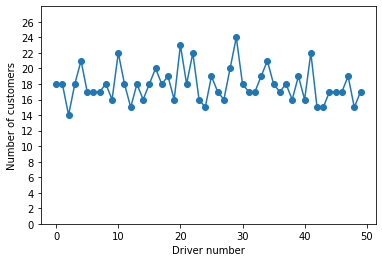

In [578]:
plt.plot([len(p) for p in mpc_paths3], '-o')
plt.ylim([0, 28])
plt.yticks([*range(0, 28, 2)])
plt.xlabel('Driver number')
plt.ylabel('Number of customers')
plt.savefig('plots/50_drivers_customers.png', dpi=600, bbox_inches='tight')

In [534]:
with open("data/g3_f_pickle.pkl", "rb" ) as f:
    fseries_pickle=pickle.load(f)

In [535]:
fseries_pickle.keys()

dict_keys(['50', '55', '60', '65', '70', '75', '80', '81', '82', '83', '85', 'Ds', '50_v', '55_v', '60_v', '65_v', '70_v', '75_v', '80_v', '81_v', '82_v', '83_v', '85_v'])

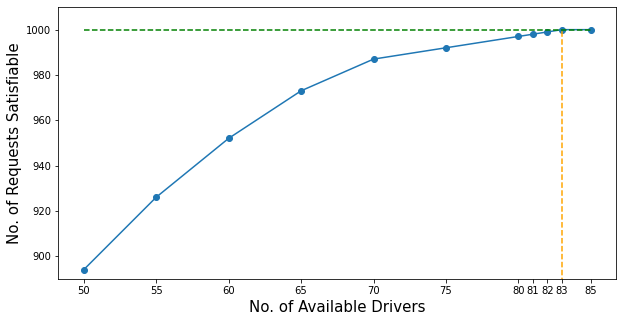

In [584]:
plt.figure(figsize=(10,5))
n_covered_requests = [fseries_pickle[str(d)+'_v'] for d in fseries_pickle['Ds']]
plt.plot(fseries_pickle['Ds'], n_covered_requests, '-o')
plt.plot([50,85],[1000,1000],'--g')
plt.plot([83,83],[800,1000],'--', color='orange')
plt.ylim([890, 1010])
plt.xlabel('No. of Available Drivers', fontsize='15')
plt.ylabel('No. of Requests Satisfiable', fontsize='15')
plt.xticks(np.concatenate([np.arange(50,81,5), [81,82,83,85]]))
plt.savefig('plots/n_requests_n_drivers.png', dpi=600, bbox_inches='tight')